# Climate Model Common Issues
In this tutorial, we're going to highlight some of the most common issues that you could potentially encounter when running 1D climate models and what are the general recommendations to fix it! You don't neccesarily need to rerun this notebook, this is more for you to look at to see what issues might look like in your model figures

By now you should have been able to run all the previous climate model notebooks. Now let's get started!

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import virga.justdoit as vj
import virga.justplotit as cldplt
jpi.output_notebook()
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray
from bokeh.plotting import show, figure

Loading BokehJS ...

## Deep Isothermal Profiles

Let's say you don't know what radiative-convective (rc) boundary guess to start with, you choose some random number and something just doesn't look right. Sometimes you might run into issues where you get an isothermal profile that hits the maximum allowable temperature in our framework. Here is what that run would look like

In [ ]:
# sonora_profile_db = '/data/sonora_bobcat/structure/structures_m+0.0'
# sonora_profile_db = '/Users/nbatalh1/Documents/data/sonora_bobcat/structures_m+0.0'

sonora_profile_db = os.path.join(os.getenv('picaso_refdata'),'sonora_grids','bobcat')

In [ ]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

teff= 2400 # Effective Temperature of your Brown Dwarf in K
grav = 10 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

gases_fly = ['CO','CH4','H2O','NH3','CO2','N2','HCN','H2','C2H2','Na','K','TiO','VO','FeH'] #PH3 excluded
opacity_ck =  jdi.opannection(method='resortrebin',preload_gases=gases_fly)# grab your opacities

In [4]:
nlevel = 91 # number of plane-parallel levels in your code

pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g17nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)

In [5]:
nofczns = 1 # number of convective zones initially

# Let's say you chose to start with level 87 as the top of the convective zone
nstr_upper = 87 # top most level of guessed convective zone 

nstr_deep = nlevel - 2 # this is always the case. Dont change this

nstr = np.array([0,nstr_upper,nstr_deep,0,0,0])

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

kz = temp_bobcat*0 + 1e2

In [ ]:
cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv)

cl_run.atmosphere(mh=100, cto_relative=2.5, chem_method='visscher',
                quench=True, cold_trap = False, no_ph3 = True, vol_rainout=True)

cl_run.inputs['atmosphere']['profile']['kz']=kz

In [ ]:
out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True, save_all_kzz = True,diseq_chem=True)

1 conv Zone, so making small adjustment
New NSTR status is  [ 0 87 89  0  0  0]
From now I will mix ['CO', 'CH4', 'H2O', 'NH3', 'CO2', 'N2', 'HCN', 'H2', 'C2H2', 'Na', 'K', 'TiO', 'VO', 'FeH'] only on--the--fly
Quench Levels are CO, CO2, NH3, HCN, PH3  [0 0 0 0]
DOING DISEQ CALCULATIONS NOW
Iteration number  0 , min , max temp  1433.131651282206 4063.77337767471 , flux balance  10.480434128567993
Iteration number  1 , min , max temp  1017.799836107896 9999.9 , flux balance  4.630146532745
Iteration number  2 , min , max temp  1068.1198440096775 9999.9 , flux balance  0.9065034395968333
Iteration number  3 , min , max temp  1062.2979475177137 9999.9 , flux balance  0.5064050419663711
Iteration number  4 , min , max temp  1055.6805430731492 9999.9 , flux balance  0.39918903835079794
Iteration number  5 , min , max temp  1051.716483873279 9999.9 , flux balance  0.37252466007549995
Iteration number  6 , min , max temp  1049.3666236797549 9999.9 , flux balance  0.3008696767701143
Iterations

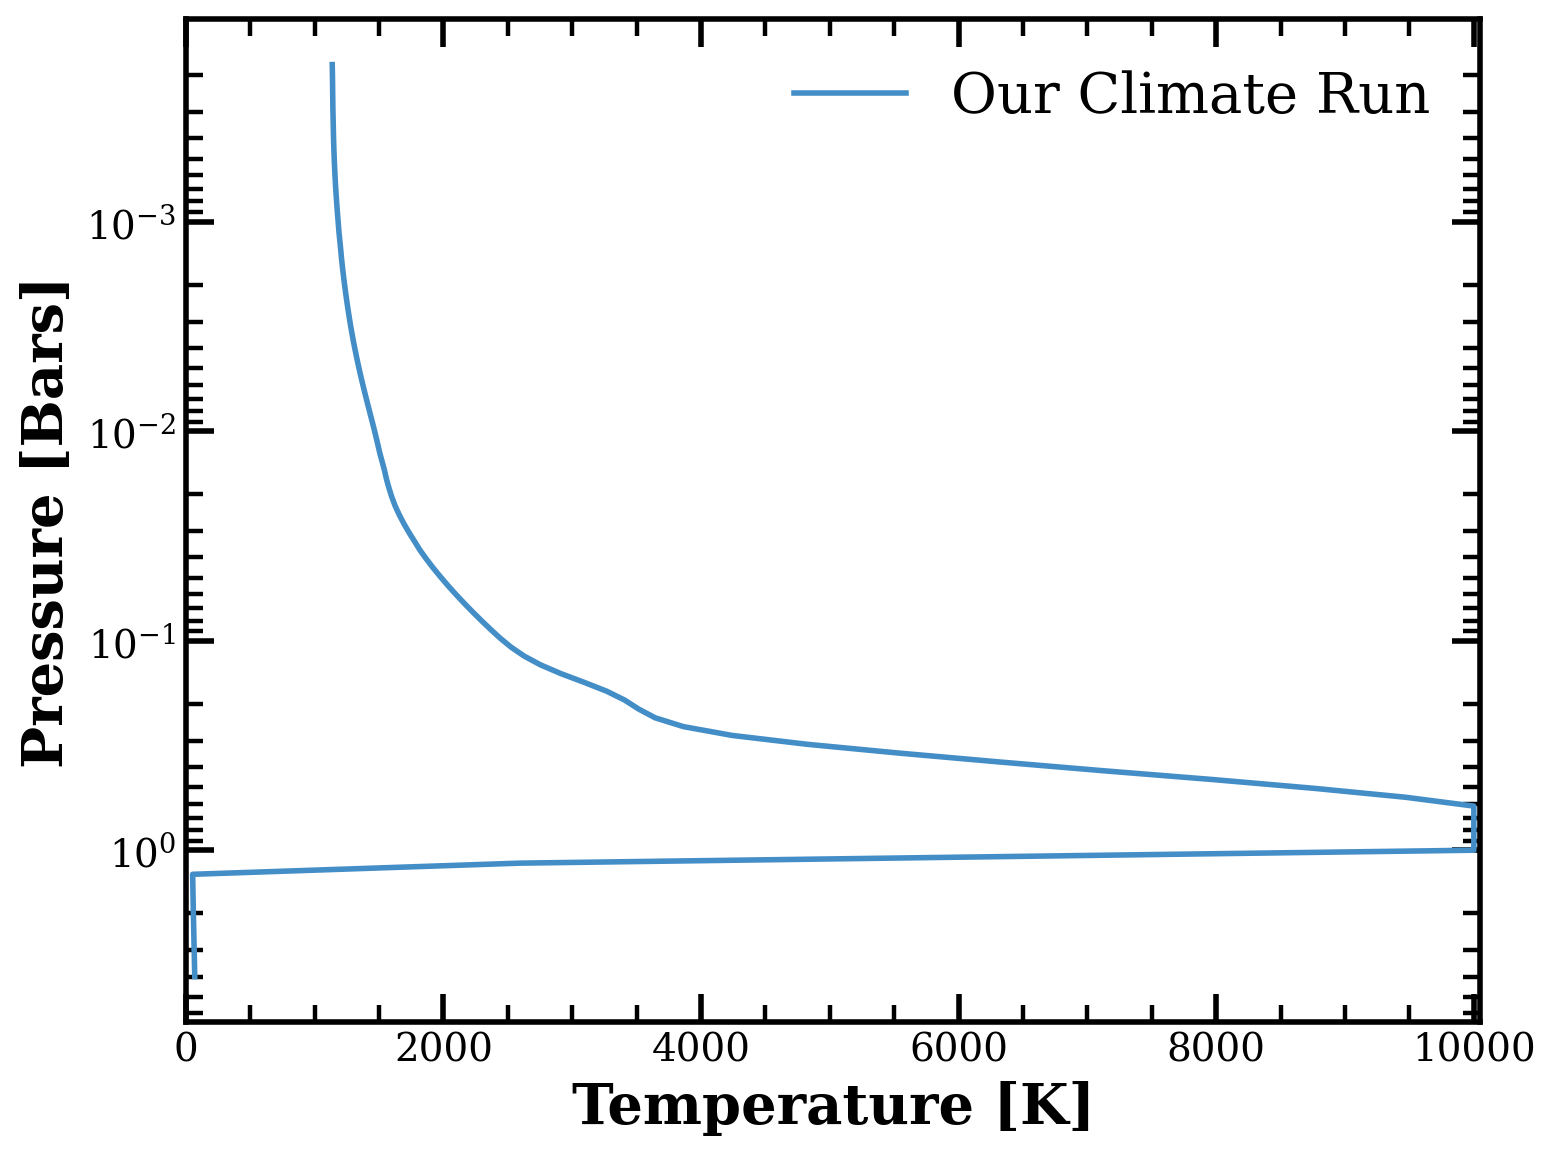

In [8]:
plt.figure(figsize=(8,6))
plt.ylabel("Pressure [Bars]")
plt.xlabel('Temperature [K]')
plt.xlim(0,max(out['temperature'])+50)
plt.gca().invert_yaxis()

plt.semilogy(out['temperature'],out['pressure'],label="Our Climate Run")

plt.legend()
plt.tight_layout()
plt.show()

You can see from this PT profile that it's hitting that maximum temperature which is why it looks isothermal and causing issues in the deeper parts of the atmosphere. 

**Recommendation** In cases like this, it's helpful to start the rc-boundary guess higher up in the atmosphere, by at least 5-10 levels.

## Starting Too High of Radiative-Convective Boundary Guess

Now let's say you tried starting with a rc boundary guess higher up in the profile since you don't want it to be too deep in the atmosphere. If you start with a guess too high up in the atmosphere you'll notice some odd behaviours as well. This is very common in both clear and cloudy models but fortunately it's very easy to visually catch this issue majority of the time. Let's look at this with a clear atmospheric model.

In [ ]:
#1 ck tables from roxana
mh = '+000'#'+0.0' #log metallicity
CtoO = '100'#'1.0' # CtoO ratio

# ck_db = f'/Users/nbatalh1/Documents/data/kcoeff_asci/sonora_2020_feh{mh}_co_{CtoO}.data.196'
ck_db = os.path.join(os.getenv('picaso_refdata'),'opacities', 'preweighted',f'sonora_2020_feh{mh}_co_{CtoO}.data.196')

In [ ]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

teff= 200 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

opacity_ck = jdi.opannection(ck_db=ck_db, method='preweighted') # grab your opacities

In [11]:
nlevel = 91 # number of plane-parallel levels in your code

pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)

Maybe you didn't want to wait forever for your model to run so you didn't want to start with a very deep `nstr_upper`, what happens if we start with a guess at let's say layer 45 (reminder in these tutorials we have 91 layers in our atmosphere)

In [12]:
nofczns = 1 # number of convective zones initially

nstr_upper = 45 # top most level of guessed convective zone 

nstr_deep = nlevel - 2 # this is always the case. Dont change this

nstr = np.array([0,nstr_upper,nstr_deep,0,0,0])

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

In [ ]:
cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv)

In [14]:
out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

Iteration number  0 , min , max temp  76.59380769907412 1452.0892839795476 , flux balance  42.45664232076407
Iteration number  1 , min , max temp  78.1896717130471 1451.7652452130196 , flux balance  42.2651603627806
Iteration number  2 , min , max temp  79.71965119789321 1451.415619168957 , flux balance  42.05927638524604
Iteration number  3 , min , max temp  81.1819065098932 1451.0384714206066 , flux balance  41.83801919041759
Iteration number  4 , min , max temp  82.60886482060083 1450.6315880102438 , flux balance  41.60028453138854
Iteration number  5 , min , max temp  84.00358049449895 1450.1924375434435 , flux balance  41.344819821257566
Iteration number  6 , min , max temp  85.35433460819581 1449.7181458101845 , flux balance  41.07021769848764
Iteration number  7 , min , max temp  86.65912208811689 1449.2057191281306 , flux balance  40.77499239331627
Iteration number  8 , min , max temp  87.92807391541616 1448.651605848857 , flux balance  40.45742828179879
Iteration number  9 , m

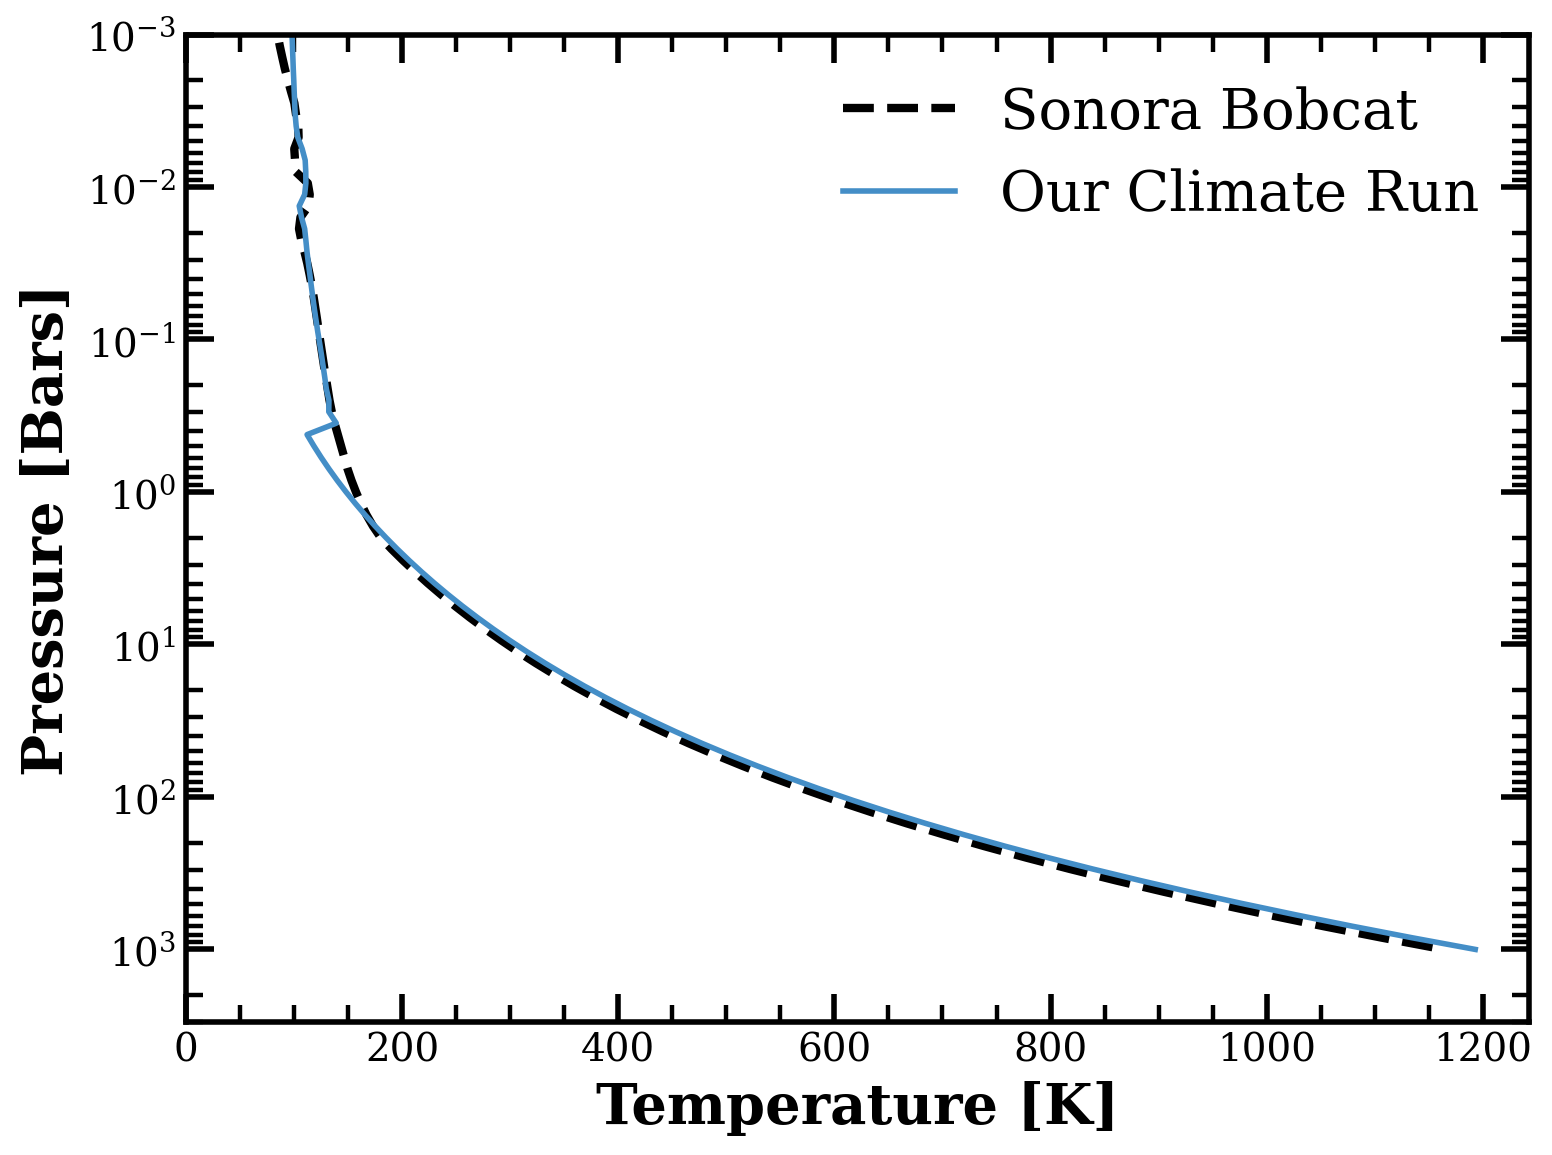

In [15]:
pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)
plt.figure(figsize=(8,6))
plt.ylabel("Pressure [Bars]")
plt.xlabel('Temperature [K]')
plt.xlim(0,max(out['temperature'])+50)
plt.ylim(3e3,1e-3)

plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="Sonora Bobcat")

plt.semilogy(out['temperature'],out['pressure'],label="Our Climate Run")

plt.legend()
plt.tight_layout()
plt.show()

So as you can see here there's this large jump in the PT profile where the profile is following the adiabat too far up. This is a clear visual clue that you need to start with a deeper `nstr_upper` initial guess, even though it says this climate model ended up converging.

Sometimes it's not as visually noticeable as this so a good way to tell if these models are good or not is by looking at dT/dP

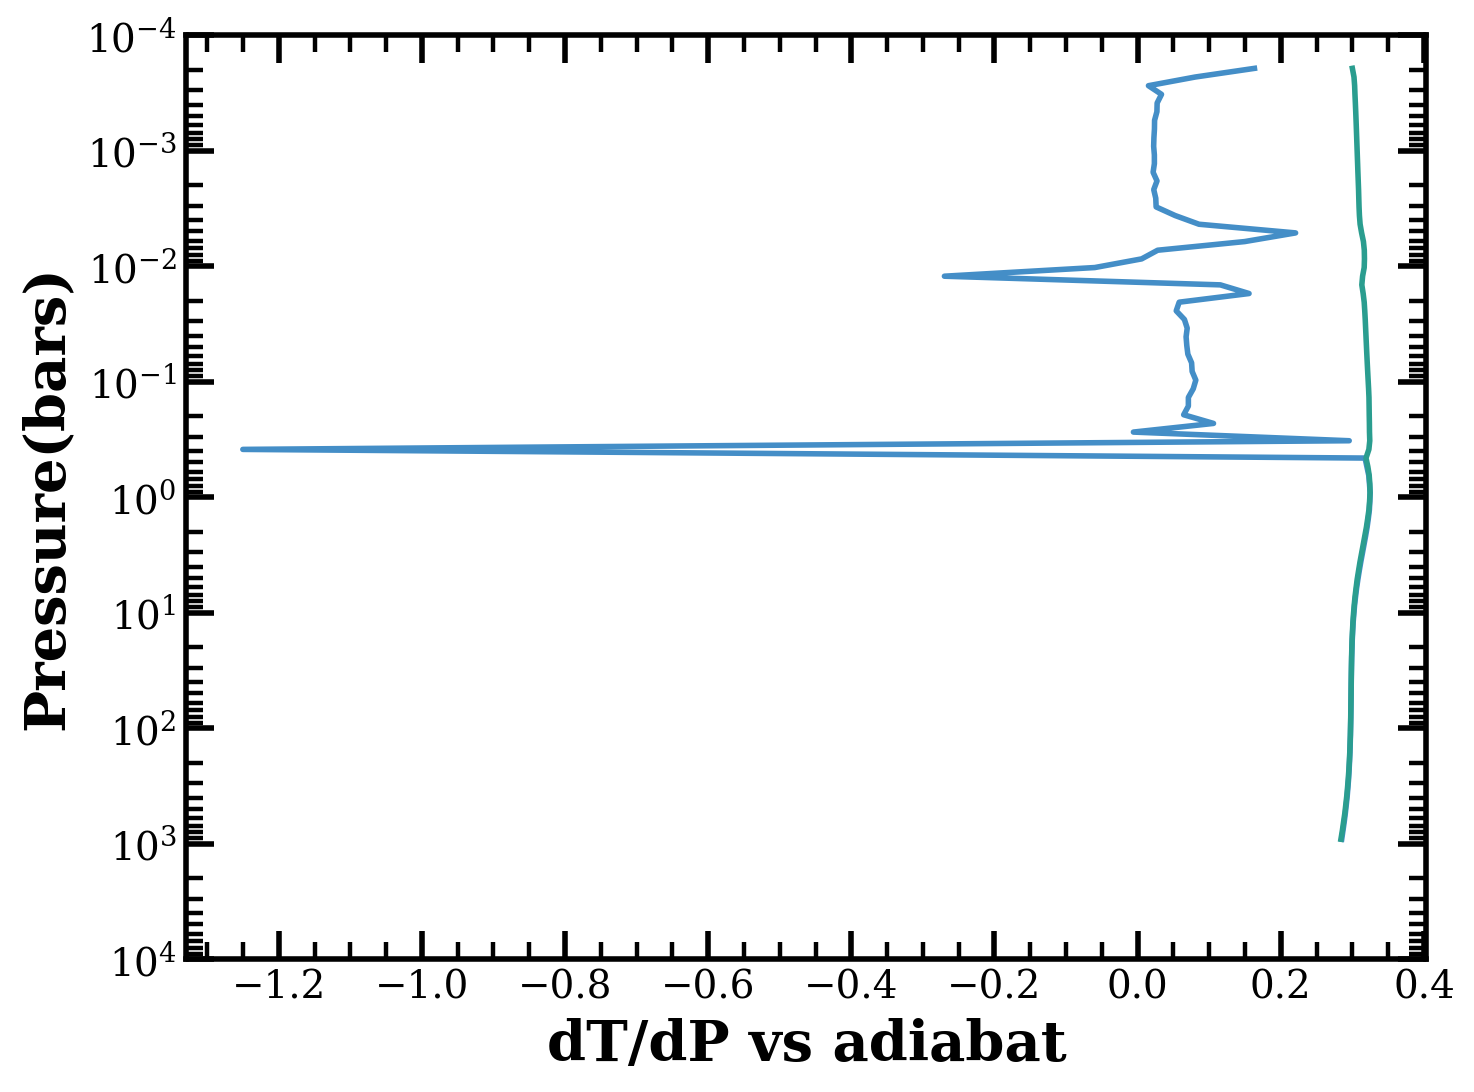

In [16]:
cp, grad, dtdp, layer_p= jpi.pt_adiabat(out,cl_run)

So here in this case, although it never goes super-adiabatic, you can see that dT/dP actually goes super negative. Anytime you see these going really far negative, it usually points to a poorly converged model.

Sometimes if you start way too high, the convective zone will reach the top of the atmosphere, PICASO will send you an error and the run will fail if that occurs.

**Recommendation**:
Generally, a conservative starting rc boundary guess is 83 (if doing 91 levels). The actual layer of where the rc boundary is going to vary depending on the surface gravity, whether there are clouds or not, the temperature of the object, etc.

### Checking if You Reached Radiative-Convective Equilibrium (RCE)

Another indicator, on top of the lapse rate figure, that indicates your model isn't well converged even though it says `YAY ENDING WITH CONVERGENCE` is to look at the F_{net}/F_{IR} output. This will indicate to us that your model might not be in radiative-convective equilibrium (RCE).

Let's check whether we achieved RCE in this case. In the convective regions for these climate models, the flux coming out of the convective layers should be in the IR. This isn't the case for the radiative layers. So when we look at the Fnet/F_IR plot, you should see a chair like behaviour where at the top of the atmosphere, there are low values of Fnet/F_IR (~1e-3 to 1e-5). Then, near the rc boundary, it should sharply increase since this is the beginning of the region where convection dominates.

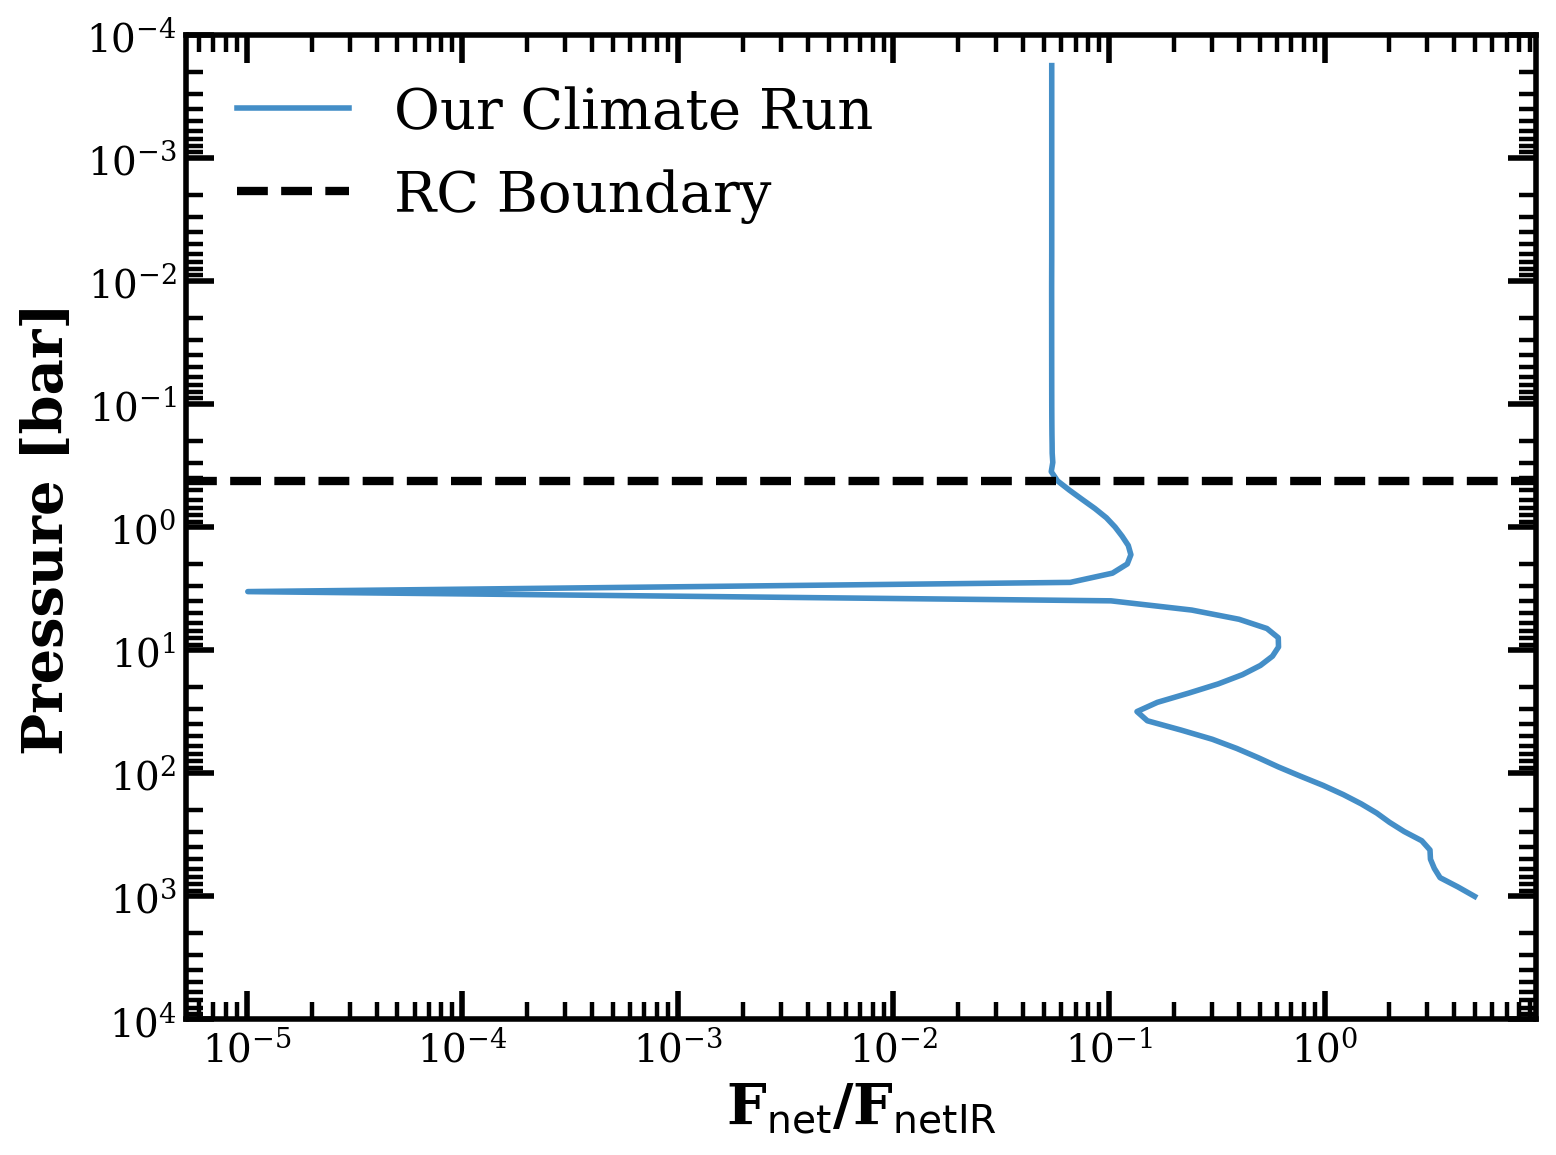

In [17]:
plt.figure(figsize=(8,6))
plt.ylabel("Pressure [bar]")
plt.xlabel(r'F$_{\rm net}$/F$_{\rm net IR}$')
plt.ylim(1e4,1e-4)

plt.loglog(abs(out['fnet/fnetir']),out['pressure'], label = "Our Climate Run")
plt.axhline(y=pressure_bobcat[out['cvz_locs'][1]],color="k",linestyle="--",linewidth=3, label = 'RC Boundary')

plt.legend()
plt.tight_layout()
plt.show()

So in this case here you can see that it's not in RCE. The fluxes are still coming out from the IR above where it's supposed to be 'radiative' and so we're not in RCE.

Now let's fix this by running a case where we have a better rc boundary guess that isn't too high and we can see what good diagnostic plots should look like

In [ ]:
#1 ck tables from roxana
mh = '+000'#'+0.0' #log metallicity
CtoO = '100'#'1.0' # CtoO ratio

# ck_db = f'/Users/nbatalh1/Documents/data/kcoeff_asci/sonora_2020_feh{mh}_co_{CtoO}.data.196'
ck_db = os.path.join(os.getenv('picaso_refdata'),'opacities', 'preweighted',f'sonora_2020_feh{mh}_co_{CtoO}.data.196')

In [ ]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

teff= 200 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

opacity_ck = jdi.opannection(ck_db=ck_db, method='preweighted') # grab your opacities

In [20]:
nlevel = 91 # number of plane-parallel levels in your code

pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)

In [21]:
nofczns = 1 # number of convective zones initially

nstr_upper = 60 # top most level of guessed convective zone 

nstr_deep = nlevel - 2 # this is always the case. Dont change this

nstr = np.array([0,nstr_upper,nstr_deep,0,0,0])

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

In [22]:
cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv)

In [23]:
out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

Iteration number  0 , min , max temp  77.3107017311313 1164.0932993203724 , flux balance  0.07946282775497292
Iteration number  1 , min , max temp  79.52119975549329 1164.316128779953 , flux balance  0.0784893786563001
Iteration number  2 , min , max temp  81.59598978389981 1164.563226837331 , flux balance  0.07741585838872722
Iteration number  3 , min , max temp  83.59988552181736 1164.8370874636955 , flux balance  0.07623340234432396
Iteration number  4 , min , max temp  85.51437117698731 1165.1406920186537 , flux balance  0.07493156902668409
Iteration number  5 , min , max temp  87.331230708044 1165.4775607034683 , flux balance  0.07349828683711697
Iteration number  6 , min , max temp  89.0745761923416 1165.851746448674 , flux balance  0.07192009204059147
Iteration number  7 , min , max temp  90.75424138161841 1166.2677975630916 , flux balance  0.07018254377124829
Iteration number  8 , min , max temp  92.37849889634514 1166.7307092515928 , flux balance  0.06827073262321869
Iteration

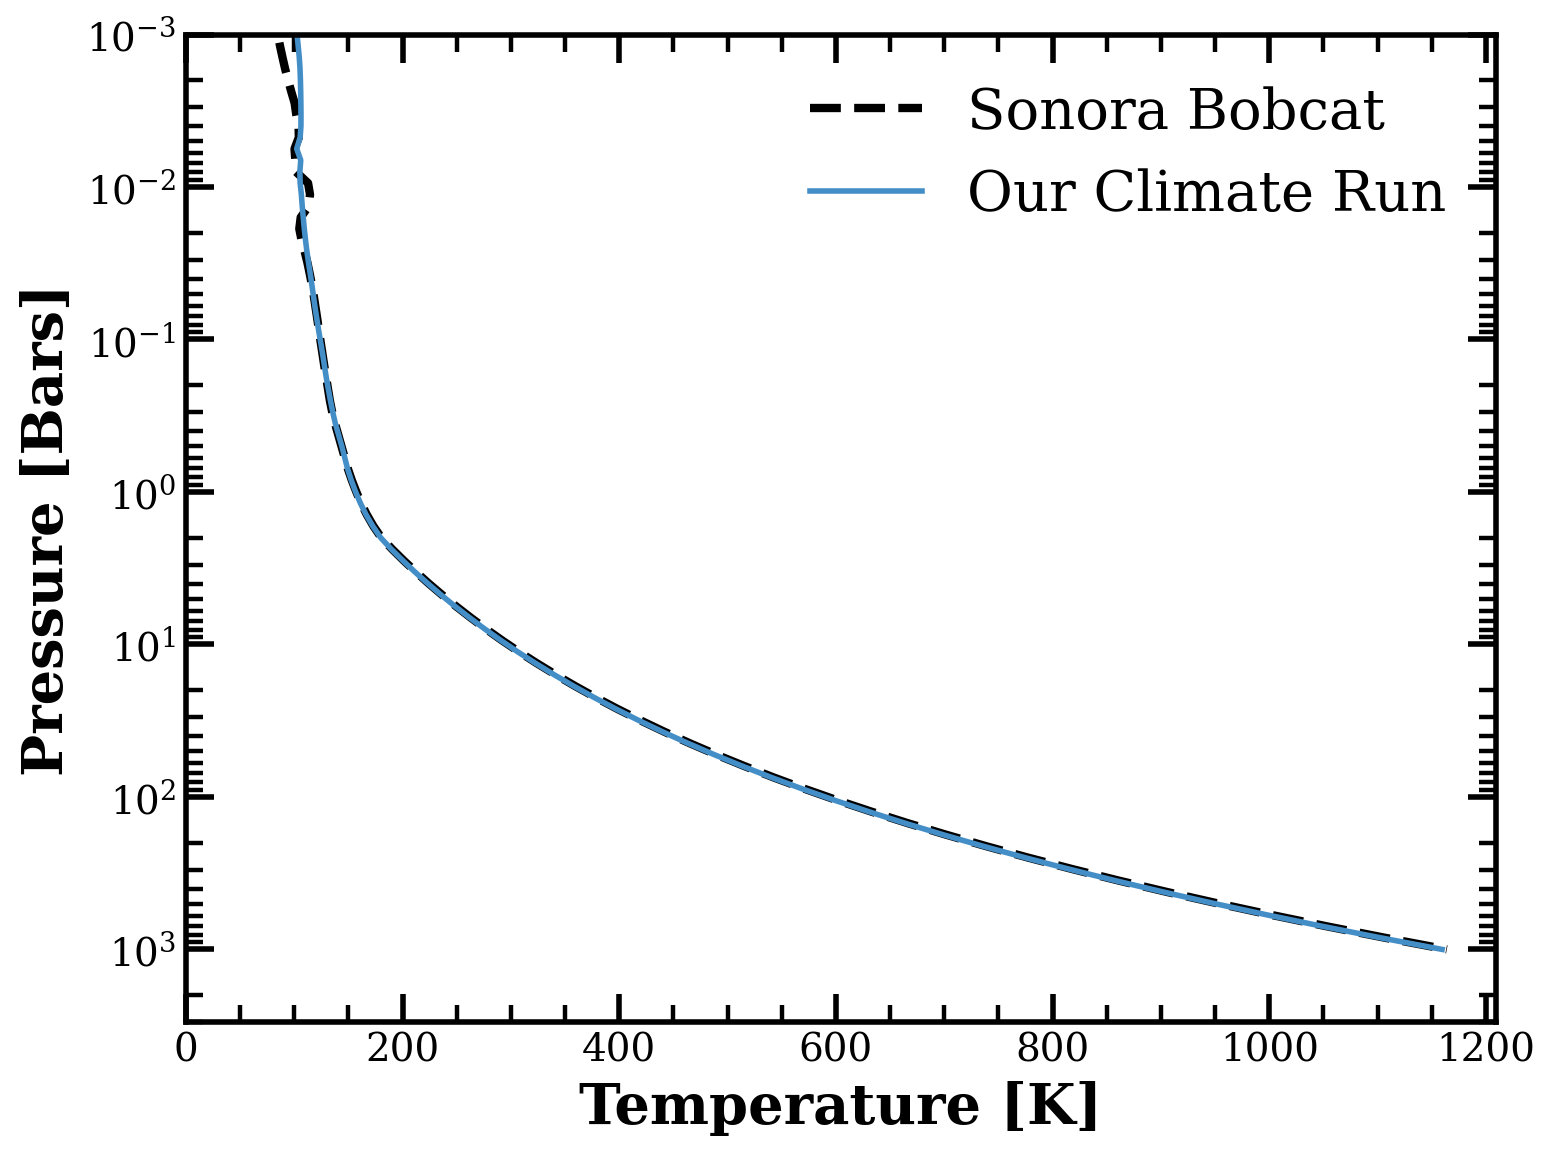

In [24]:
pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)
plt.figure(figsize=(8,6))
plt.ylabel("Pressure [Bars]")
plt.xlabel('Temperature [K]')
plt.xlim(0,max(out['temperature'])+50)
plt.ylim(3e3,1e-3)

plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="Sonora Bobcat")

plt.semilogy(out['temperature'],out['pressure'],label="Our Climate Run")

plt.legend()
plt.tight_layout()
plt.show()

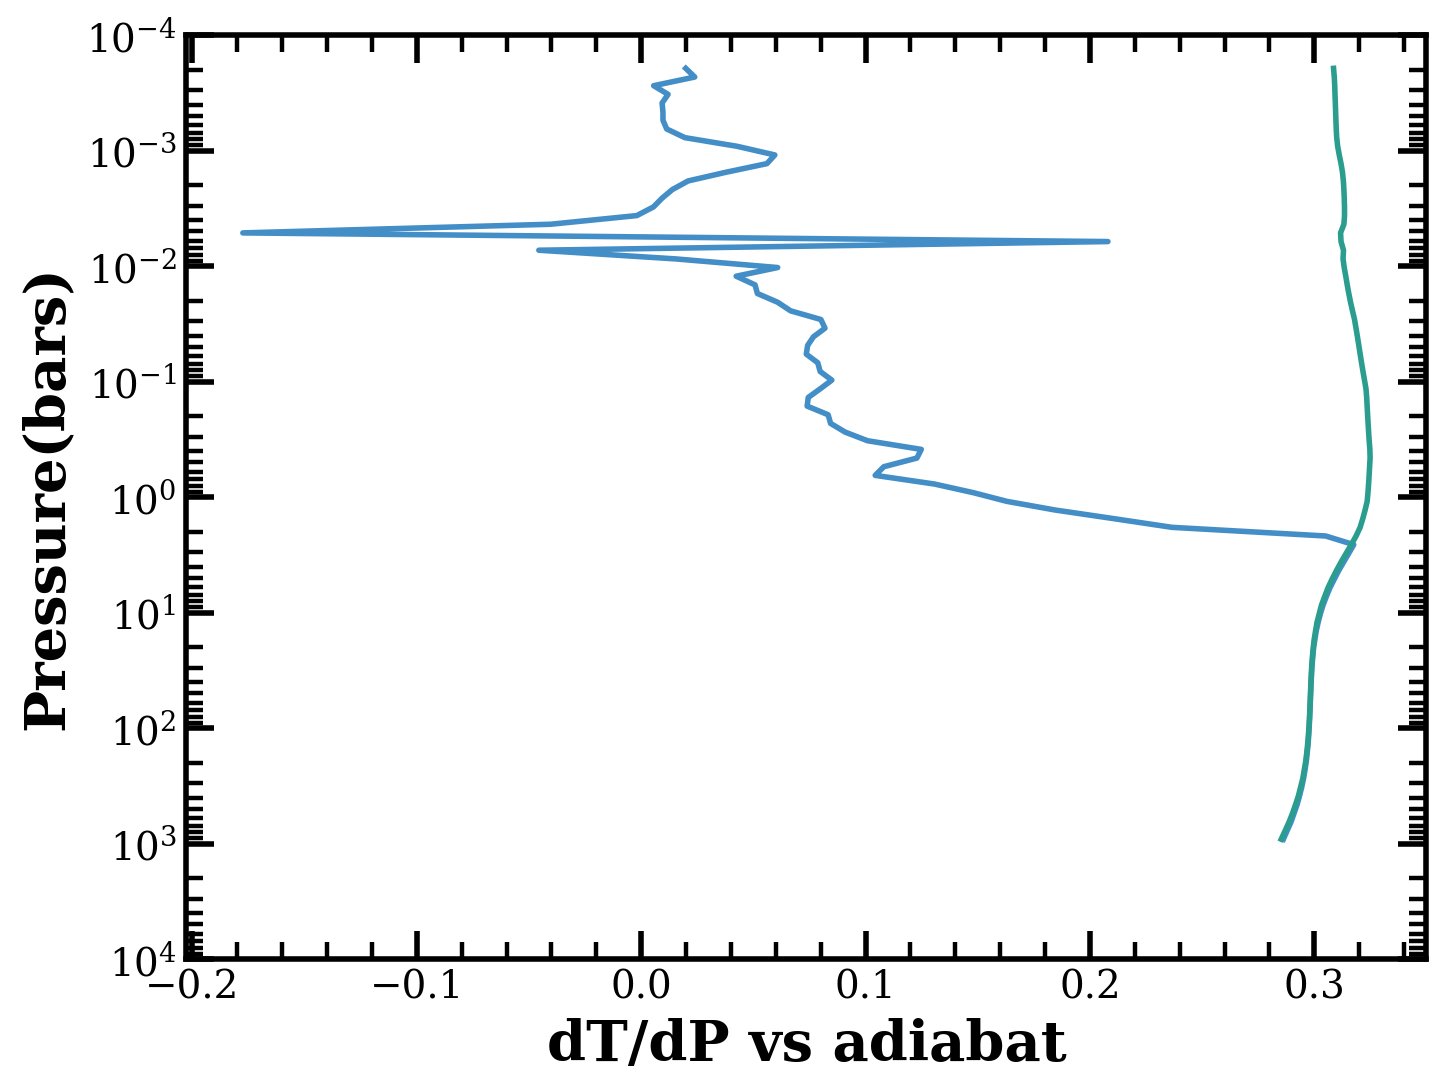

In [25]:
cp, grad, dtdp, layer_p= jpi.pt_adiabat(out,cl_run)

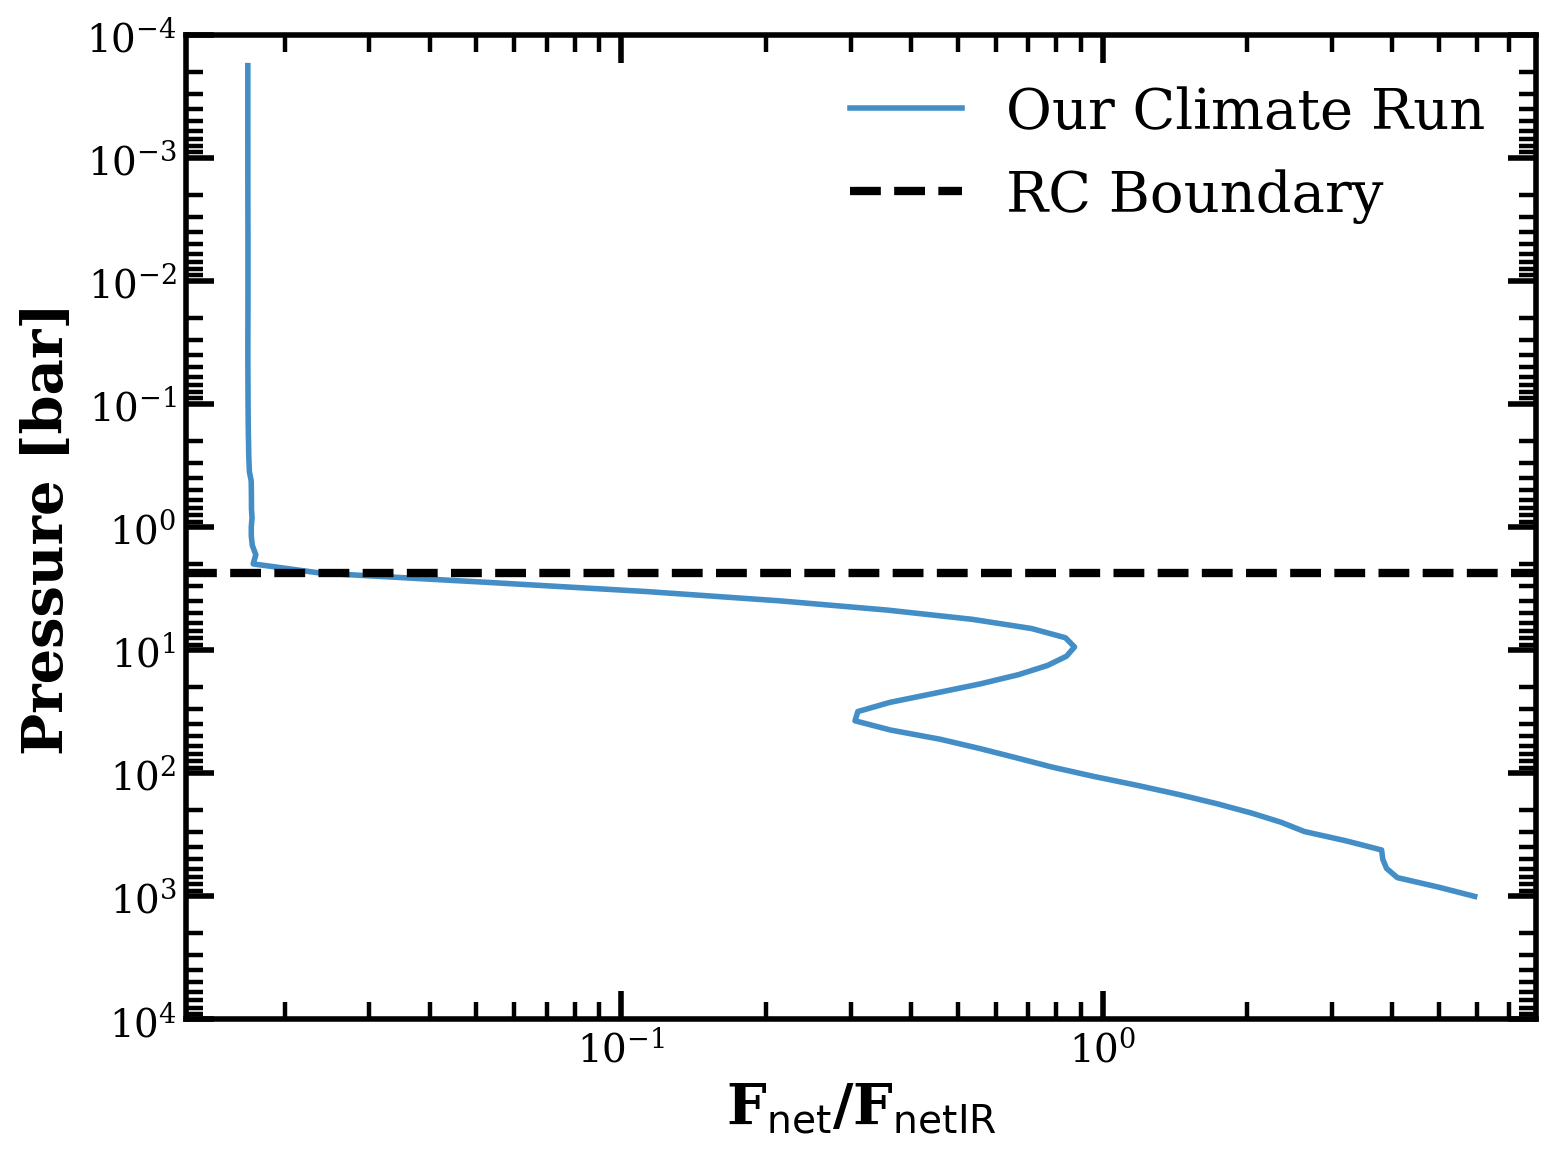

In [26]:
plt.figure(figsize=(8,6))
plt.ylabel("Pressure [bar]")
plt.xlabel(r'F$_{\rm net}$/F$_{\rm net IR}$')
plt.ylim(1e4,1e-4)

plt.loglog(abs(out['fnet/fnetir']),out['pressure'], label = "Our Climate Run")
plt.axhline(y=pressure_bobcat[out['cvz_locs'][1]],color="k",linestyle="--",linewidth=3, label = 'RC Boundary')

plt.legend()
plt.tight_layout()
plt.show()

So here we see the really nice behavior we expected in a well converged model in the Fnet/Fnet-IR diagnostic plots. Keep these two diagnostic plots in mind when running models for a sanity check!

Sometimes you might have to restart with the resultant profile and start with an rc boundary guess a few layers deeper in the atmosphere to reconverge the profile. Other things to tune within the code include the `egp_stepmax` temperature threshold, but consult with your Sonora team member to discuss this further.